# Cross-validation
Once we develop a rule-based or ML-based strategy, it's time to backtest it. The first time around we obtain a low Sharpe ratio we're unhappy with, we decide to tweak our strategy. Eventually, after multiple iterations of tweaking parameters, we end up with a "flawless" combination of parameters and a strategy with an exceptional Sharpe ratio. However, in live trading the performance took a different turn: we essentially tanked and lost money. What went wrong?

Markets inherently have noise - small and frequent idiosyncrasies in the price data. When modelling a strategy, we want to avoid optimizing for one specific period because there is a chance the model adapts so closely to historical data that it becomes ineffective in predicting the future. It'd be like tuning a car specifically for one racetrack, while expecting it to perform well everywhere. Especially with vectorbt, which enables us to search extensive databases of historical market data for patterns, it is often possible to develop elaborate rules that appear to predict price development with close accuracy (see p-hacking) but make random guesses when applied to data outside the sample the model was constructed from.

Overfitting (aka curve fitting) usually occurs for one or more of the following reasons: mistaking noise for signal, and overly tweaking too many parameters. To curb overfitting, we should use cross-validation (CV), which involves partitioning a sample of data into complementary subsets, performing the analysis on one subset of data called the training or in-sample (IS) set, and validating the analysis on the other subset of data called the validation or out-of-sample (OOS) set. This procedure is repeated until we have multiple OOS periods and can draw statistics from these results combined. The ultimate questions we need to ask ourselves: is our choice of parameters robust in the IS periods? Is our performance robust on the OOS periods? Because if not, we're shooting in the dark, and as a quant investor we should not leave room for second-guessing when real money is at stake.

Consider a simple strategy around a moving average crossover.

First, we'll pull some data:

In [1]:
import numpy as np
import pandas as pd
from numba import njit
import vectorbtpro as vbt
vbt.settings.set_theme("dark")
vbt.settings.plotting["layout"]["width"] = 800
vbt.settings.plotting['layout']['height'] = 200
import warnings
warnings.filterwarnings("ignore")

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, LogisticRegression
from sklearn.svm import SVR, SVC
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=42) # random forest classifier


/Users/ericervin/opt/anaconda3/envs/datascience/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


pull in some data

Let's construct a parameterized mini-pipeline that takes data and the parameters, and returns the Sharpe ratio that should reflect the performance of our strategy on that test period:

### Modeling
The class Splitter can also be helpful in cross-validating ML models. In particular, you can casually step upon a class SKLSplitter that acts as a regular cross-validator from scikit-learn by subclassing BaseCrossValidator. We'll demonstrate its usage on a simple classification problem of predicting the best entry and exit timings.

Before we start, we need to decide on features and labels that should act as predictor and response variables respectively. Features are usually multi-columnar time-series DataFrames where each row contains multiple data points (one per column) that should predict the same row in labels. Labels are usually a single-columnar time-series Series that should be predicted. Ask yourself the following questions to easily come up with a decision:

"How can the future performance be represented, preferably as a single number? Should it be the price at the next bar, the average price change over the next week, a vector of weights for rebalancing, a boolean containing a signal, or something else?"
"What kind of data that encompasses the past performance is likely to predict the future performance? Should it be indicators, news sentiment index, past backtesting results, or something else?"
"Which ML model can handle such a task?" (remember that most models are limited to just a couple of specific feature and label formats!)
For the sake of an example, we'll fit a random forest classifier on all TA-Lib indicators stacked along columns to predict the binary labels generated by the label generator TRENDLB, where 1 means an uptrend and 0 means a downtrend. Sounds like fun 😌

Build a pipeline to impute and (standard-)normalize the data, [reduce the dimensionality](https://scikit-learn.org/stable/auto_examples/compose/plot_digits_pipe.html) of the features, as well as fit one of the [linear](https://scikit-learn.org/stable/modules/linear_model.html) models to predict the average price change over the next n bars (i.e., regression task!). Based on each prediction, you can then decide whether a position is worth opening or closing out. 

# Let's experiment

Smaller resolution but using dollar bars

In [2]:
data_path = '/Users/ericervin/Documents/Coding/data-repository/data/BTCUSDT_1m_futures.pkl' 

futures_1m = vbt.BinanceData.load(data_path)


# Helper functions
Create dollar bars and add them to the original df

In [3]:

def dollar_bar_func(ohlc_df, dollar_bar_size):
    # Calculate dollar value traded for each row
    ohlc_df['DollarValue'] = ohlc_df['Close'] * ohlc_df['Volume']
    
    # Calculate cumulative dollar value
    ohlc_df['CumulativeDollarValue'] = ohlc_df['DollarValue'].cumsum()
    
    # Determine the number of dollar bars
    num_bars = int(ohlc_df['CumulativeDollarValue'].iloc[-1] / dollar_bar_size)
    
    # Generate index positions for dollar bars
    bar_indices = [0]
    cumulative_value = 0
    for i in range(1, len(ohlc_df)):
        cumulative_value += ohlc_df['DollarValue'].iloc[i]
        if cumulative_value >= dollar_bar_size:
            bar_indices.append(i)
            cumulative_value = 0
    
    # Create a new dataframe with dollar bars
    dollar_bars = []
    for i in range(len(bar_indices) - 1):
        start_idx = bar_indices[i]
        end_idx = bar_indices[i + 1]
        
        dollar_bar = {
            'Open': ohlc_df['Open'].iloc[start_idx],
            'High': ohlc_df['High'].iloc[start_idx:end_idx].max(),
            'Low': ohlc_df['Low'].iloc[start_idx:end_idx].min(),
            'Close': ohlc_df['Close'].iloc[end_idx],
            'Volume': ohlc_df['Volume'].iloc[start_idx:end_idx].sum(),
            'Quote volume': ohlc_df['Quote volume'].iloc[start_idx:end_idx].sum(),
            'Trade count': ohlc_df['Trade count'].iloc[start_idx:end_idx].sum(),
            'Taker base volume': ohlc_df['Taker base volume'].iloc[start_idx:end_idx].sum(),
            'Taker quote volume': ohlc_df['Taker quote volume'].iloc[start_idx:end_idx].sum()
        }
        
        if isinstance(ohlc_df.index, pd.DatetimeIndex):
            dollar_bar['Open Time'] = ohlc_df.index[start_idx]
            dollar_bar['Close Time'] = ohlc_df.index[end_idx] - pd.Timedelta(milliseconds=1)
        elif 'Open Time' in ohlc_df.columns:
            dollar_bar['Open Time'] = ohlc_df['Open Time'].iloc[start_idx]
            dollar_bar['Close Time'] = ohlc_df['Open Time'].iloc[end_idx] - pd.Timedelta(milliseconds=1)
        
        dollar_bars.append(dollar_bar)
    
    dollar_bars_df = pd.concat([pd.DataFrame([bar]) for bar in dollar_bars], ignore_index=True)
    
    return dollar_bars_df

# Create a simple function to simplify the number so we can use it in our column names
def simplify_number(num):
    """
    Simplifies a large number by converting it to a shorter representation with a suffix (K, M, B).
    simplify_number(1000) -> 1K
    """
    suffixes = ['', 'K', 'M', 'B']
    suffix_index = 0

    while abs(num) >= 1000 and suffix_index < len(suffixes) - 1:
        num /= 1000.0
        suffix_index += 1

    suffix = suffixes[suffix_index] if suffix_index > 0 else ''
    simplified_num = f'{int(num)}{suffix}'

    return simplified_num

def merge_and_fill_dollar_bars(original_df, dollar_bars_df, dollar_bar_size):
    # Add prefix to column names in dollar bars dataframe
    dollar_bar_prefix = f'db_{simplify_number(dollar_bar_size)}_'
    dollar_bars_df_renamed = dollar_bars_df.add_prefix(dollar_bar_prefix)

    # Convert 'Open Time' columns to pandas datetime format and set them as index
    dollar_bars_df_renamed.index = pd.to_datetime(dollar_bars_df_renamed[dollar_bar_prefix + 'Open Time'])

    # Merge the dataframes on the index
    merged_df = original_df.merge(dollar_bars_df_renamed, how='left', left_index=True, right_index=True)

    # Set the flag for a new dollar bar with prefix
    merged_df[dollar_bar_prefix + 'NewDBFlag'] = ~merged_df[dollar_bar_prefix + 'Close'].isna()

    # Forward fill the NaN values for all columns except the new dollar bar flag
    columns_to_ffill = [col for col in merged_df.columns if col != dollar_bar_prefix + 'NewDBFlag']
    merged_df[columns_to_ffill] = merged_df[columns_to_ffill].fillna(method='ffill')

    # Fill the remaining NaN values in the new dollar bar flag column with False
    merged_df[dollar_bar_prefix + 'NewDBFlag'] = merged_df[dollar_bar_prefix + 'NewDBFlag'].fillna(False)
    
    # Assign the renamed 'Open Time' column back to the dataframe
    merged_df[dollar_bar_prefix + 'Open Time'] = merged_df[dollar_bar_prefix + 'Open Time']

    return merged_df





# Calculate DB
Calc Dollar bars and then add technical analysis features

Uncomment this section if you want to run different size dollar bars

In [5]:
# dollar_bar_size = 90_000_000
# btc_dollar_bars = dollar_bar_func(futures_1m.get(), dollar_bar_size=dollar_bar_size)
# btc_dollar_bars.index = pd.to_datetime(btc_dollar_bars['Open Time'])
# btc_dollar_bars.shape

(124942, 11)

In [6]:
# Convert the dataframe back into a vbt data object
# btc_90M_db_vbt = vbt.BinanceData.from_data(btc_dollar_bars)


Load the dollar bars from pickle file

In [ ]:
btc_90M_db_vbt = vbt.BinanceData.load('btc_90M_db_vbt.pkl')

Take a small slice of the data

In [98]:
# Save the dollarbars to a pickle file
btc_90M_db_vbt.save('btc_90M_db_vbt.pkl')

PosixPath('btc_90M_db_vbt.pkl')

In [90]:
data = btc_90M_db_vbt['2021-01-01':'2021-04-30']
data.shape

In [93]:
# Generate the features (X) using TA-Lib indicators
X = data.run("talib")
# add trend label as a feature
X['trend'] = data.run("trendlb", .5, 0.2, mode="binary").labels # add trend label as a feature
# X['dayofweek'] = data['Open Time'].dayofweek # add day of week as a feature
# Now we are trying to generate future price predictions so we will set the y labels to the price change n periods in the future
n = 150 # number of periods in the future to predict
y = (data.close.shift(-n) / data.close - 1).rolling(n).mean() # future price change we use rolling mean to smooth the data

# Preprocessing steps to handle NaNs
X = X.replace([-np.inf, np.inf], np.nan) # replace inf with nan
invalid_column_mask = X.isnull().all(axis=0) | (X.nunique() == 1) # drop columns that are all nan or have only one unique value
X = X.loc[:, ~invalid_column_mask] # drop invalid columns
invalid_row_mask = X.isnull().any(axis=1) | y.isnull() # drop rows that have nan in any column or in y

# Drop invalid rows in X and y
X = X.loc[~invalid_row_mask]
y = y.loc[~invalid_row_mask]

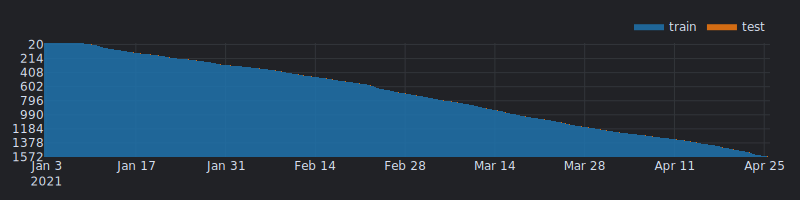

In [94]:

# Construct the pipeline
steps = [
    ('imputation', SimpleImputer(strategy='mean')),  # Imputation replaces missing values
    ('scaler', StandardScaler()),  # StandardScaler normalizes the data
    ('pca', PCA(n_components=15)),  # PCA reduces dimensionality
    
    # Choose one of the following models
    # ('model', Ridge())  # Ridge regression is used as the prediction model
    # ('model', LinearRegression())  # Linear regression is used as the prediction model
    # ('model', LogisticRegression())  # Logistic regression is used as the prediction model
    # ('model', Lasso())  # Lasso regression is used as the prediction model
    # ('model', ElasticNet())  # ElasticNet regression is used as the prediction model
    # ('model', SVR())  # Support Vector Regression is used as the prediction model
    ('model', XGBRegressor(objective='reg:squarederror'))  # XGBoost regression is used as the prediction model
]
pipeline = Pipeline(steps)

# Cross-validate
cv = vbt.SKLSplitter(
    "from_expanding",
    min_length=1000,
    offset=10,
    split=-10,
    set_labels=["train", "test"]
)

cv_splitter = cv.get_splitter(X)
# Plot the cross-validation splits
cv_splitter.plot().show_svg()


In [95]:
# Use your pipeline to compress features and fit the model for predictions
print(f'Pipeline Steps :{pipeline.steps}')
pipeline.fit(X, y)  # Fit the pipeline on the entire dataset    
print(f'Pipeline Score :{pipeline.score(X, y)}')  # Score the pipeline on the entire dataset of training data
scores = cross_val_score(pipeline, X, y, cv=cv, scoring="r2", n_jobs=-1) # how well the model generalizes to unseen data
average_score = np.mean(scores)
print(f'Average cross-validation score: {average_score}')


Pipeline Steps :[('imputation', SimpleImputer()), ('scaler', StandardScaler()), ('pca', PCA(n_components=15)), ('model', XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...))]
Pipeline Score :0.782919925174216
Average cross-validation score: -7488.686393360989


Mean Squared Error (MSE): 0.001156107519654505
Root Mean Squared Error (RMSE): 0.034001581134625265
Mean Absolute Error (MAE): 0.025376397044492835
R-squared: 0.28657145305229026


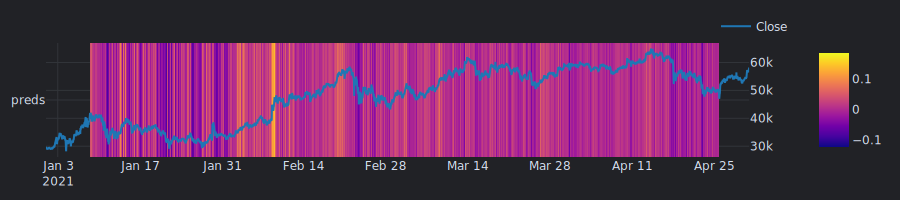

In [96]:


# Predictions
X_slices = cv_splitter.take(X)
y_slices = cv_splitter.take(y)

test_labels = []
test_preds = []
for split in X_slices.index.unique(level="split"):  
    X_train_slice = X_slices[(split, "train")]  
    y_train_slice = y_slices[(split, "train")]
    X_test_slice = X_slices[(split, "test")]
    y_test_slice = y_slices[(split, "test")]
    slice_pipeline = pipeline.fit(X_train_slice, y_train_slice)  
    test_pred = slice_pipeline.predict(X_test_slice)  
    test_pred = pd.Series(test_pred, index=y_test_slice.index)
    test_labels.append(y_test_slice)
    test_preds.append(test_pred)

test_labels = pd.concat(test_labels).rename("labels")  
test_preds = pd.concat(test_preds).rename("preds")

# Show the accuracy of the predictions
# Assuming test_labels and test_preds are your true and predicted values
mse = mean_squared_error(test_labels, test_preds)
rmse = np.sqrt(mse)  # or use mean_squared_error with squared=False
mae = mean_absolute_error(test_labels, test_preds)
r2 = r2_score(test_labels, test_preds)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared: {r2}")

# Visualize the predictions as a heatmap plotted against the price
data.close.vbt.overlay_with_heatmap(test_preds).show_svg()

Start                         2021-01-08 14:11:00+00:00
End                           2021-04-25 21:23:00+00:00
Period                                            15730
Start Value                                       100.0
Min Value                                         100.0
Max Value                                    308.313242
End Value                                    273.983892
Total Return [%]                             173.983892
Benchmark Return [%]                          16.103513
Total Time Exposure [%]                       98.029243
Max Gross Exposure [%]                       118.728619
Max Drawdown [%]                              25.557923
Max Drawdown Duration                            3692.0
Total Orders                                         70
Total Fees Paid                                     0.0
Total Trades                                         70
Win Rate [%]                                  47.826087
Best Trade [%]                                38

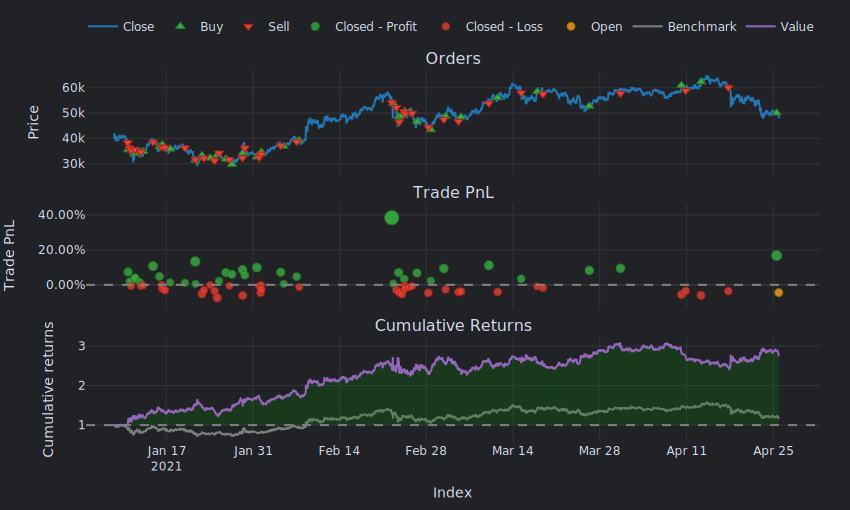

In [101]:
pf = vbt.Portfolio.from_signals(
    data.close[test_preds.index], # use only the test set
    test_preds > 0.05, # long when probability of price increase is greater than 2%
    test_preds < -0.05, # short when probability prediction is less than -5%
    direction="both" # long and short
)
print(pf.stats())
pf.plot().show_svg()
# Show first period
# pf['2018':'2021'].plot().show_svg()
# Show second period
# pf['2021':'2023'].plot().show_svg()

In [100]:
pf.stats().to_csv('stats-jan-apr-2021.csv')